## STEP 1: ENVIRONMENT SETUP


In [1]:
!pip install torch torchvision matplotlib numpy

from google.colab import files
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image


In [12]:
# Upload your kaggle.json file using the appropriate method
#files.upload()


In [3]:
# Make a directory named .kaggle
!mkdir -p ~/.kaggle

# Move kaggle.json to this directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

# Unzip the downloaded dataset
!unzip best-artworks-of-all-time.zip -d ./art_dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_61.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_62.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_63.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_64.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_65.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_66.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_67.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_68.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_69.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_7.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_70.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_8.jpg  
  inflating: ./art_dataset/resized/resized/Henri_Rousseau_9.jpg  
  inflating: ./art_dataset/resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  in

## STEP 2: DATA PREPARATION


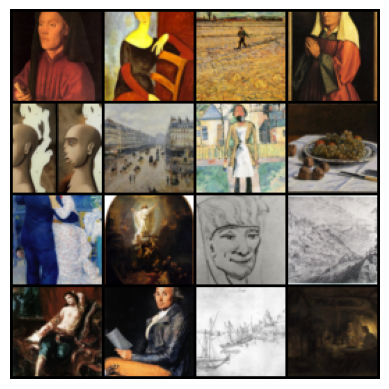

In [5]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(64),             # Resize images to 64x64
    transforms.CenterCrop(64),         # Center crop to 64x64
    transforms.ToTensor(),             # Convert images to tensors
    transforms.Normalize([0.5], [0.5], [0.5])  # Normalize to [-1, 1]
])

# Path to the extracted dataset
dataset_path = './art_dataset/images'

# Load the dataset using ImageFolder
art_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(art_dataset, batch_size=128, shuffle=True, num_workers=2)

# Visualize some sample images
sample_batch = next(iter(dataloader))
sample_images = sample_batch[0]
grid_img = make_grid(sample_images[:16], nrow=4, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

## STEP 3: MODEL DEFINITIONS


In [6]:
os.makedirs('/content/generated_samples', exist_ok=True)


In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, ngf, nc):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1)


## STEP 4: HYPERPARAMETERS AND MODEL INITIALIZATION


In [9]:
# Hyperparameters
latent_dim = 100
ngf = 64  # Generator feature map size
ndf = 64  # Discriminator feature map size
nc = 3    # Number of color channels

# Create the models
generator = Generator(latent_dim, ngf, nc).to('cuda')
discriminator = Discriminator(nc, ndf).to('cuda')

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## STEP 5: TRAINING LOOP


In [10]:
num_epochs = 50  # Adjust based on your dataset and available resources
sample_interval = 500  # Interval for saving generated images

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to('cuda')
        batch_size = real_images.size(0)

        # Train Discriminator
        real_labels = torch.ones(batch_size, device='cuda')
        fake_labels = torch.zeros(batch_size, device='cuda')

        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, latent_dim, 1, 1, device='cuda')
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Generator tries to fool the discriminator
        g_loss.backward()
        optimizer_G.step()

        if i % sample_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss_real.item() + d_loss_fake.item()}, G Loss: {g_loss.item()}')
            with torch.no_grad():
                sample_noise = torch.randn(64, latent_dim, 1, 1, device='cuda')
                sample_images = generator(sample_noise)
                save_image((sample_images + 1) / 2, f'generated_samples/epoch_{epoch}_step_{i}.png')

Epoch [0/50], Step [0/69], D Loss: 1.391015648841858, G Loss: 3.4512996673583984
Epoch [1/50], Step [0/69], D Loss: 0.16858169646002352, G Loss: 6.7834649085998535
Epoch [2/50], Step [0/69], D Loss: 0.30850088596343994, G Loss: 4.336329936981201
Epoch [3/50], Step [0/69], D Loss: 0.29410117864608765, G Loss: 3.383721351623535
Epoch [4/50], Step [0/69], D Loss: 0.5174073278903961, G Loss: 1.8977460861206055
Epoch [5/50], Step [0/69], D Loss: 0.7066381871700287, G Loss: 4.112099647521973
Epoch [6/50], Step [0/69], D Loss: 0.36229123175144196, G Loss: 3.483264923095703
Epoch [7/50], Step [0/69], D Loss: 0.6066087484359741, G Loss: 4.922908782958984
Epoch [8/50], Step [0/69], D Loss: 0.4636852592229843, G Loss: 2.434147357940674
Epoch [9/50], Step [0/69], D Loss: 0.2492624670267105, G Loss: 4.450488090515137
Epoch [10/50], Step [0/69], D Loss: 0.5082255136221647, G Loss: 4.4082183837890625
Epoch [11/50], Step [0/69], D Loss: 0.6971305906772614, G Loss: 5.033377647399902
Epoch [12/50], Step

## STEP 6: VISUALIZE GENERATED IMAGES


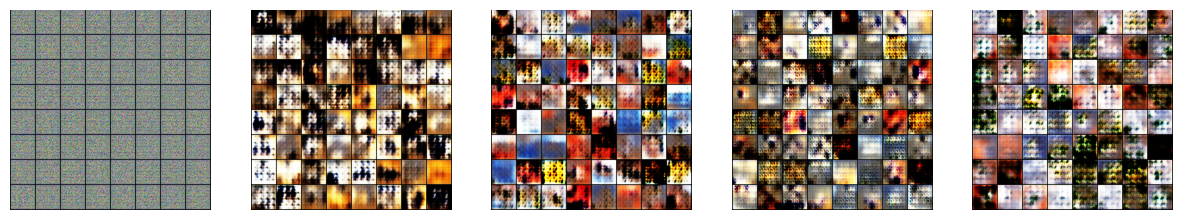

In [11]:
# Directory where the generated images are saved
image_dir = '/content/generated_samples'

# List the files in the directory
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])

# Number of images to display
num_images = 5  # Change this to the number of images you want to display

# Display the images using matplotlib
plt.figure(figsize=(15, 5))
for i in range(num_images):
    # Open the image file
    img = Image.open(image_files[i])

    # Plot the image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes

# Show the plot
plt.show()
